# Clearing the Smaug

An attempt to recreate the network in tests.ipynb except sorting by tag so we have 3 less possible outputs

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout

import tools

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [11]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


Filters

In [12]:
# filter by realistic situation where we have 3 tags and >=4 jets
nj4 = s_table.njets>=4   # >=4 jets exist
nt3 = s_table.nbtags==3  # 3 b tags
nj4nt3 = nj4 & nt3
events = s_table[nj4nt3]
n_events = len(events)
print(n_events)

312386


Get some quantities we'll use a lot

In [14]:
pt = events["resolved_lv"].pt
eta = events["resolved_lv"].eta
phi = events["resolved_lv"].phi
tag = events["tag"] # tag[index] = [1, 1, 1, 0, 0, ...] (len >= 4)
truth = events["truth"]

Then prepare for keras stuff

In [23]:
# filler value for padded pt, eta, phi
fill = -10
# cut off and pad
padded_true = pad_sequences(truth,padding='post')[:,:cutoff]
padded_tag = pad_sequences(tag, padding='post')[:,:cutoff]
padded_pt = pad_sequences(pt, padding='post', dtype='float32', value = fill)[:,:cutoff]
padded_eta = pad_sequences(eta, padding='post', dtype='float32', value = fill)[:,:cutoff]
padded_phi = pad_sequences(phi, padding='post', dtype='float32', value = fill)[:,:cutoff]

In [29]:
# 1 = should have been tagged but wasn't. 0 = correctly tagged (or not tagged)
untagged = np.logical_xor(padded_true, padded_tag)

# n_untagged[i] = number of untagged real jets in i-th event
n_untagged = np.count_nonzero(untagged, axis=1)

# for now, consider only untagged events where one jet is not tagged
untagged = untagged[n_untagged == 1]

print(n_untagged == 1)
# where does the untagged jet occur?
#missed_jet_index = np.where(untagged == 1).astype(np.int32)
#print(missed_jet_index)

[False False False ...  True  True  True]


In [28]:
# scale data to be ML-friendly
scaler_pt = StandardScaler()
scaler_eta = StandardScaler()
scaler_phi = StandardScaler()

print(pt.shape, untagged.shape)

pt = padded_pt[n_untagged == 1]
eta = padded_eta[n_untagged == 1]
phi = padded_phi[n_untagged == 1]


# s for scaled
s_pt = scaler_pt.fit_transform(pt)
s_eta = scaler_eta.fit_transform(eta)
s_phi = scaler_phi.fit_transform(phi)
# stack pt, eta, phi for input into neural network
s_in = np.column_stack((s_pt, s_eta, s_phi))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 172366 but corresponding boolean dimension is 312386

Split data into training, validation, and testing subsets

In [13]:
# split missed_jet into training, validation, testing subsets
train, val, test = splitTVT(missed_jet, trainfrac=0.7, testfrac=0.2)


To do: experiment with different kinds of networks

In [14]:
model = Sequential()
model.add(Dense(30, input_dim=30, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
        # compile model
optimizer = Adam(lr=5e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [16]:
history = model.fit(s_in[train], missed_jet[train], validation_data=(s_in[val], missed_jet[val]), epochs = 200, batch_size = 200, verbose = 1)

- val_acc: 0.7030
Epoch 59/200
120656/120656 [==============================] - 1s 7us/step - loss: 0.7362 - acc: 0.6989 - val_loss: 0.7276 - val_acc: 0.7033
Epoch 60/200
120656/120656 [==============================] - 1s 7us/step - loss: 0.7353 - acc: 0.6997 - val_loss: 0.7271 - val_acc: 0.7031
Epoch 61/200
120656/120656 [==============================] - 1s 7us/step - loss: 0.7344 - acc: 0.6992 - val_loss: 0.7259 - val_acc: 0.7040
Epoch 62/200
120656/120656 [==============================] - 1s 7us/step - loss: 0.7335 - acc: 0.7000 - val_loss: 0.7248 - val_acc: 0.7042
Epoch 63/200
120656/120656 [==============================] - 1s 7us/step - loss: 0.7327 - acc: 0.7007 - val_loss: 0.7240 - val_acc: 0.7052
Epoch 64/200
120656/120656 [==============================] - 1s 7us/step - loss: 0.7318 - acc: 0.7012 - val_loss: 0.7229 - val_acc: 0.7051
Epoch 65/200
120656/120656 [==============================] - 1s 7us/step - loss: 0.7308 - acc: 0.7017 - val_loss: 0.7221 - val_acc: 0.7059
Ep

<Figure size 432x288 with 0 Axes>

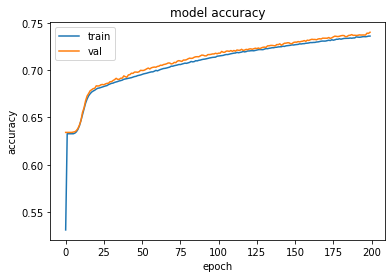

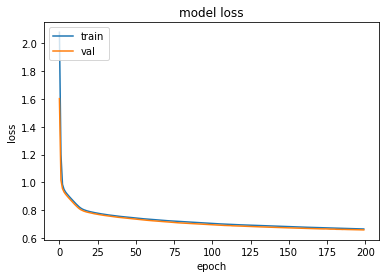

In [17]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
plt.show()


    # summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
plt.show()